
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain Anual Weather Types (AWT) following the methodology explained in Anderson et al. (2019)


inputs required: 
  * Sea Surface Temperature Anomalies (SSTA) extracted from the Extended Reconstructed Sea Surface Temperature v4 (ERSSTv4; Huang et al., (2015)). Rectangular region from 120°E to 280°E and 5°N to 5°S 
  
in this notebook:
  * Construct SSTA Hovmöller diagrams
  * Perform PCA to the Hovmöller diagrams
  * K-means to the PCA obtaining 6 AWT
  * Synthetic generation of tri-variate annual PCs (APC1,APC2, and APC3)
  * Synthetic generation of AWT based on a second-order markov chain


### Workflow:

<div>
<img src="resources/nb01_01.png" width="400px">
</div>



In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import pickle
from datetime import datetime

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.pca import PCA_LatitudeAverage
from teslakit.kma import KMA_simple
from teslakit.statistical import CopulaSimulation
from teslakit.alr import ALR_WRP

from teslakit.plotting.awt import Plot_AWTs_EOFs, Plot_AWTs, Plot_AWTs_Dates, Plot_AWTs_Validation
from teslakit.plotting.pcs import Plot_PCs_Compare_3D, Plot_PCs_WT



## Database and Site parameters

In [4]:
# --------------------------------------
# Teslakit database

p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [5]:
# --------------------------------------
# load data and set parameters

SST = db.Load_SST()  # SST Predictor
var_name = 'sst'

# SST Predictor PCA parameters
pca_year_ini = 1880
pca_year_end = 2019
pca_month_ini = 6
pca_month_end = 5
num_clusters = 6
repres = 0.95

# ALR parameters
alr_markov_order = 2

# PCs copula generation parameters (PCs 1, 2, 3)
num_PCs_rnd = 1000
kernels = ['KDE', 'KDE', 'KDE']

# Simulation
num_sims = 100
y1_sim = 2000
y2_sim = 3000



## SST  - Principal Components Analysis

Anomalies are computed by removing 11-year running averages for each month at every node. The monthly longitudinal location of anomalously warm water and its temporal behavior during the year was preserved in the AWT by averaging monthly SSTA values at each longitude to construct Hovmöller diagrams (Hovmöller, 1949). Each diagram begins in June and ends in the following May to capture SSTA variability throughout the boreal winter.

EOF1 explains 48% of the variance, predominantly related to the seesaw effect of warm water anomalies located either east or west of 165°E. The yearly PC values of EOF1 strongly correlate with the average annual ONI (R2=0.94) and average annual NINO3.4 (R2=0.91) indices, indicating that the PCA of Hovmöller space captures the same dominant interannual variability identified by classical ENSO indices. EOF2 (11% of the variance) is predominantly associated with shifting seasonal anomalies in the east Pacific, while EOF3 (8% of the variance) exhibits a temporal and spatial pattern akin to a Kelvin wave of an SSTA propagating west to east during northern hemisphere summer and fall (see figures below). 

In [6]:
# --------------------------------------
# Principal Components Analysis SST data

# PCA (anomalies, latitude average)
SST_PCA = PCA_LatitudeAverage(SST, var_name, pca_year_ini, pca_year_end, pca_month_ini, pca_month_end);
print(SST_PCA)

# store SST PCs
db.Save_SST_PCA(SST_PCA)


<xarray.Dataset>
Dimensions:        (n_components: 140, n_features: 972, n_lon: 81)
Dimensions without coordinates: n_components, n_features, n_lon
Data variables:
    PCs            (n_components, n_components) float64 4.959 ... 1.427e-15
    EOFs           (n_components, n_features) float64 -0.009881 ... 0.01164
    variance       (n_components) float64 444.8 103.5 ... 1.926e-05 2.05e-30
    var_anom_std   (n_features) float64 0.2705 0.2754 0.2969 ... 1.017 0.8508
    var_anom_mean  (n_features) float64 -0.0009864 -0.001207 ... -0.001398
    time           (n_components) datetime64[ns] 1880-06-01 ... 2019-06-01
    pred_lon       (n_lon) float64 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
Attributes:
    method:   anomalies, latitude averaged


In [7]:
# PCA data for plots

lon  = SST_PCA.pred_lon.values[:]
PCs  = SST_PCA.PCs.values[:]
EOFs = SST_PCA.EOFs.values[:]
vari = SST_PCA.variance.values[:]
time = SST_PCA.time.values[:]


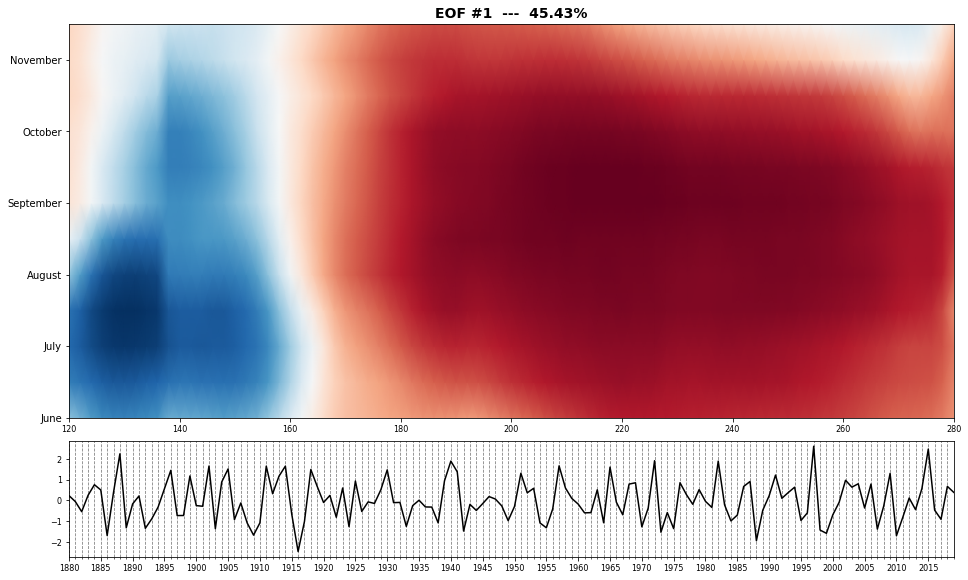

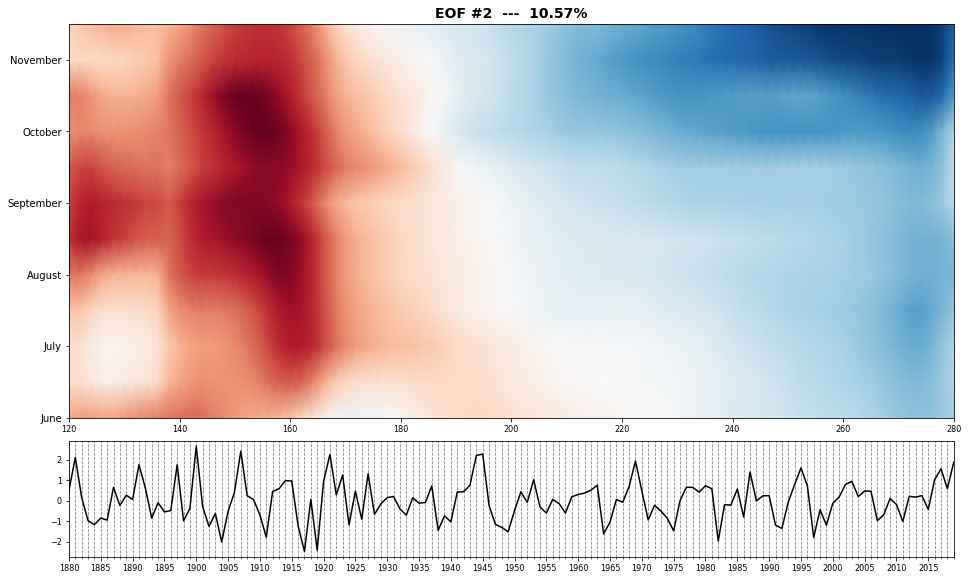

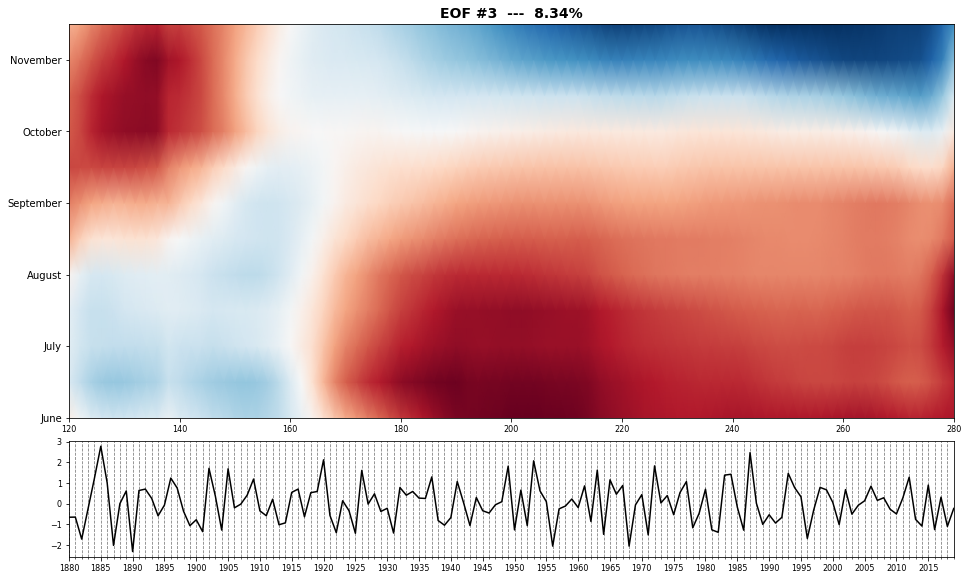

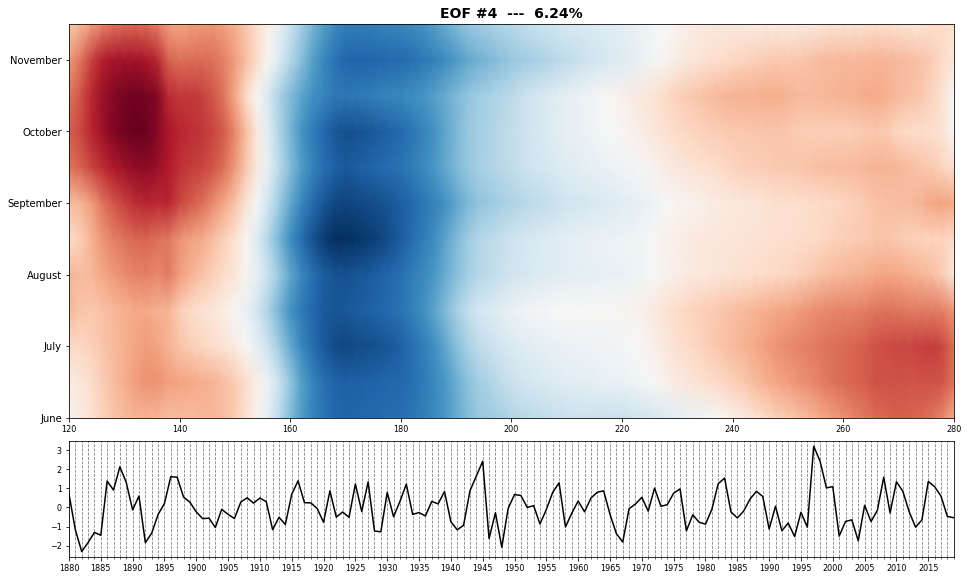

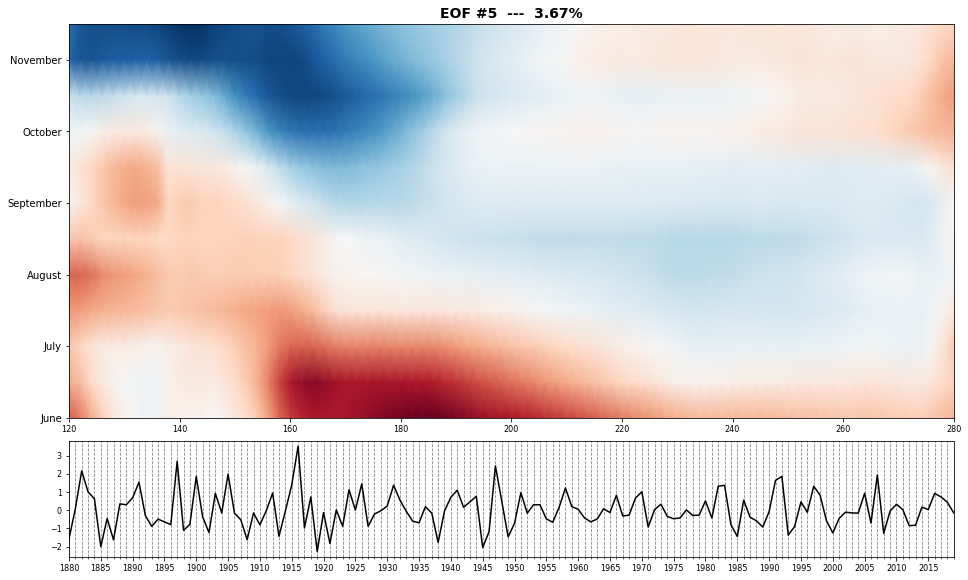

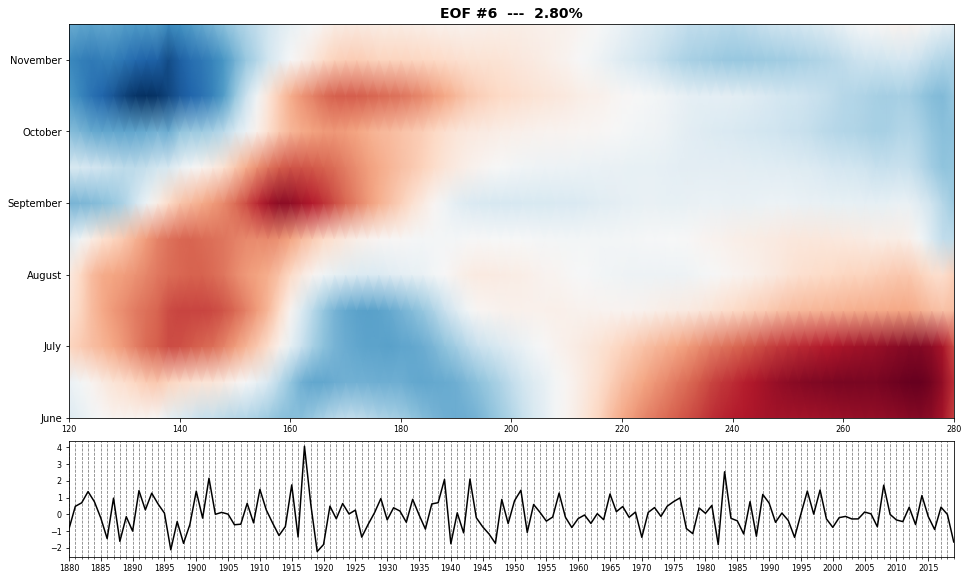

In [8]:
# Plot first 6 EOFs 

Plot_AWTs_EOFs(PCs, EOFs, vari, time, lon, 6);




## SST - KMeans Classification --> Annual Weather Types

The Annual PCs are classified into 6 representative clusters based on k-means algorithm, defined as **Annual Weather Types (AWTs)**

Annual weather type #1 (**AWT#1**) clusters years of positive SSTA in the east Pacific, which are representative of **canonical El Niño** years and includes the classic examples of 1982-83, 1997-98, and 2015-16. **AWT#2** clusters **Modoki El Niño** years, with the largest anomalies slightly further west along the equator than AWT#1, and identifies such Modoki years as 1994-95, 2002-03, and 2009-10 (Ashok et al., 2007). The opposite end of the spectrum is **AWT#6**, which exhibits negative SSTA in the east Pacific representative of **La Niña** years. Other ENSO states identified by the clustering method are interpreted as transition years between the El Niño/La Niña extremes. AWT#3 identifies increasing positive SSTA throughout the year and often occurred prior to El Niño, while AWT#4 exhibits the opposite SSTA behavior and is a precursor to La Niña. 

In [15]:
# --------------------------------------
# KMA Classification 

SST_AWTs = KMA_simple(SST_PCA, num_clusters, repres)
print(SST_AWTs)

# store SST AWTs
db.Save_SST_KMA(SST_AWTs)


<xarray.Dataset>
Dimensions:     (n_clusters: 6, n_features: 28, n_pcacomp: 140, n_pcafeat: 972)
Dimensions without coordinates: n_clusters, n_features, n_pcacomp, n_pcafeat
Data variables:
    bmus        (n_pcacomp) int64 1 2 4 3 3 3 5 1 0 5 4 ... 5 5 3 4 1 0 2 2 1 2
    cenEOFs     (n_clusters, n_features) float64 36.47 -5.722 ... -0.1035
    centroids   (n_clusters, n_pcafeat) float64 -0.4385 -0.5791 ... -0.2477
    Km          (n_clusters, n_pcafeat) float64 -0.1196 -0.1607 ... -0.2121
    group_size  (n_clusters) int64 18 28 14 29 20 31
    PCs         (n_pcacomp, n_features) float64 4.959 5.007 ... 0.7712 -1.634
    variance    (n_pcacomp) float64 444.8 103.5 81.65 ... 1.926e-05 2.05e-30
    time        (n_pcacomp) datetime64[ns] 1880-06-01 1881-06-01 ... 2019-06-01


In [16]:
# KMA data for plots
bmus = SST_AWTs.bmus.values[:]
time = SST_AWTs.time.values[:]
Km   = SST_AWTs.Km.values[:]


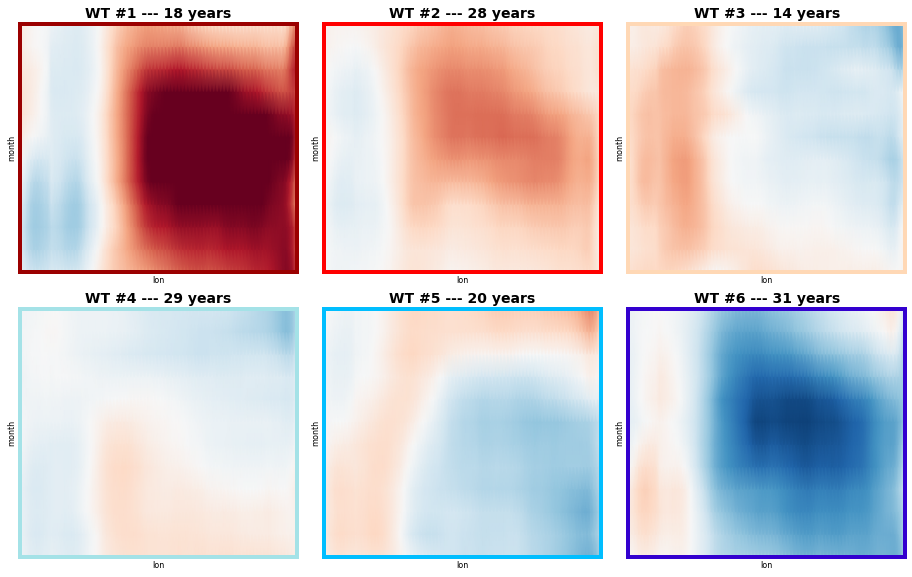

In [17]:
# Plot Annual Weather Types
Plot_AWTs(bmus, Km, num_clusters, lon);


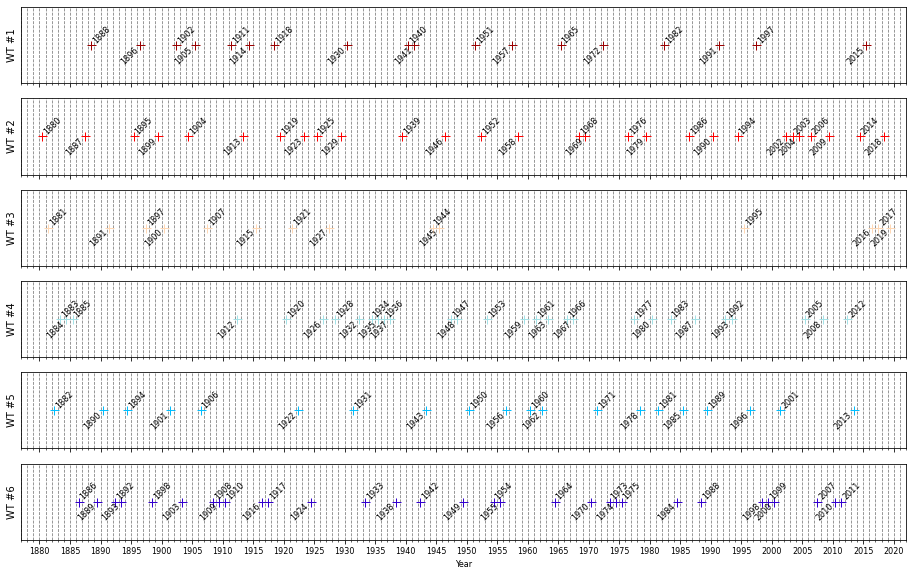

In [19]:
# Plot year/label AWTs
Plot_AWTs_Dates(bmus, time, num_clusters);


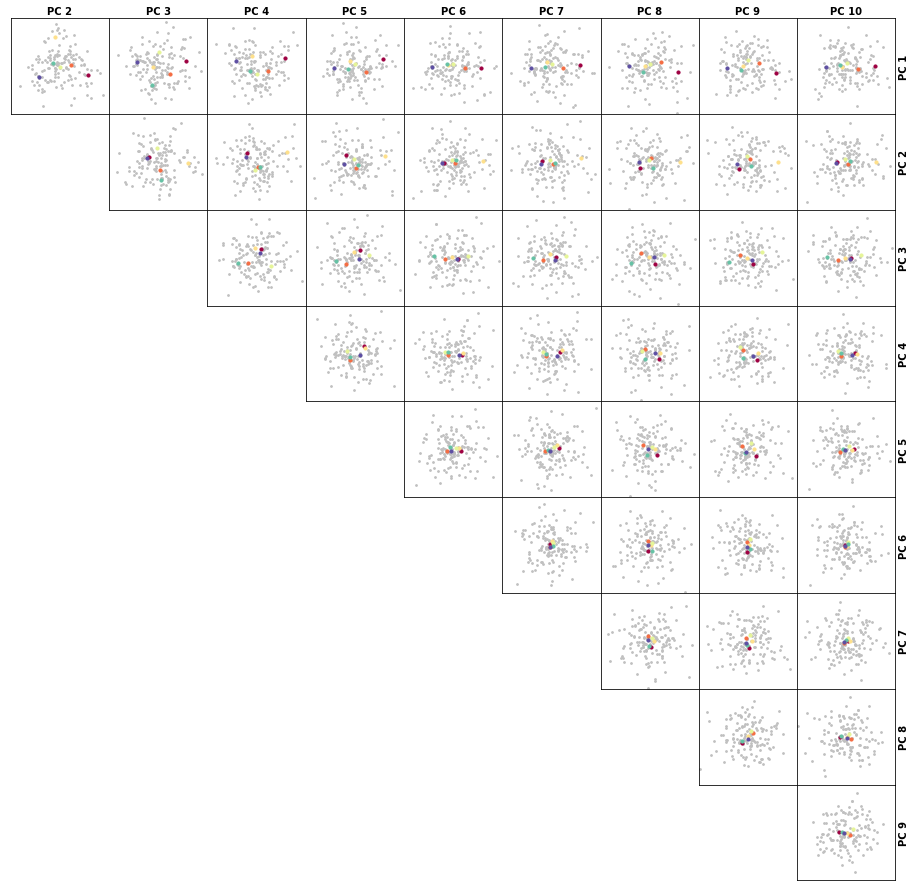

In [20]:
# Plot PCs with AWTs centroids
Plot_PCs_WT(PCs, vari, bmus, num_clusters, n=10);


## Synthetic AWT

Categorical AWTs were converted to principal component space by defining **tri-variate gaussian copulas** (e.g. Wahl et al., 2012; Masina et al., 2015) for each AWT using the marginal distributions of its respective three PC components APC1, APC2, and APC3. Each simulated categorical ENSO is thus defined by a random number generator converted to a triplet of APC1, APC2, and APC3 from the appropriate copula, effectively providing synthetic time series with the potential to not only produce new chronologies, but also new SSTA behavior (i.e., create El Niño and La Niña events statistically consistent with observations but not exact replicas of the limited number of historical observations).

The chronological sequencing of **AWTs was found significant to a second-order Markov chain**, and simulated synthetic time series from the Markov chain reproduced not only the total probability and transition probabilities but also the average occurrence interval and persistence of each ENSO state. See the autoregressive logistic regression section below.

In [21]:
# --------------------------------------
# PCs123 random generation with Copulas

bmus = SST_AWTs.bmus.values[:]
PCs  = SST_AWTs.PCs.values[:]
vari = SST_AWTs.variance.values[:]

# first 3 PCs
PC1 = np.divide(PCs[:,0], np.sqrt(vari[0]))
PC2 = np.divide(PCs[:,1], np.sqrt(vari[1]))
PC3 = np.divide(PCs[:,2], np.sqrt(vari[2]))

# for each AWT: generate copulas and simulate data
PCs_fit = {}
PCs_rnd = {}
for ic in range(num_clusters):

    # find all the best match units 
    ind = np.where(bmus == ic)[:]

    # PCs for weather type
    PC123 = np.column_stack((PC1[ind], PC2[ind], PC3[ind]))

    # statistical simulate PCs using copulas with KDE (kernel density estimation)
    PC123_rnd = CopulaSimulation(PC123, kernels, num_PCs_rnd)

    # store data at dictionaries
    PCs_fit['{0}'.format(ic+1)] = PC123
    PCs_rnd['{0}'.format(ic+1)] = PC123_rnd
    
# store PCs used for fitting and simulated
db.Save_SST_PCs_fit_rnd(PCs_fit, PCs_rnd)


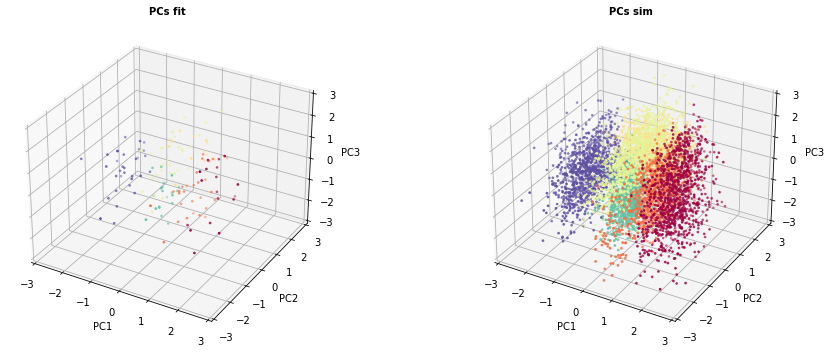

In [22]:
# Plot Weather Type 3D PCs for fit and random generation data
Plot_PCs_Compare_3D(PCs_fit, PCs_rnd);


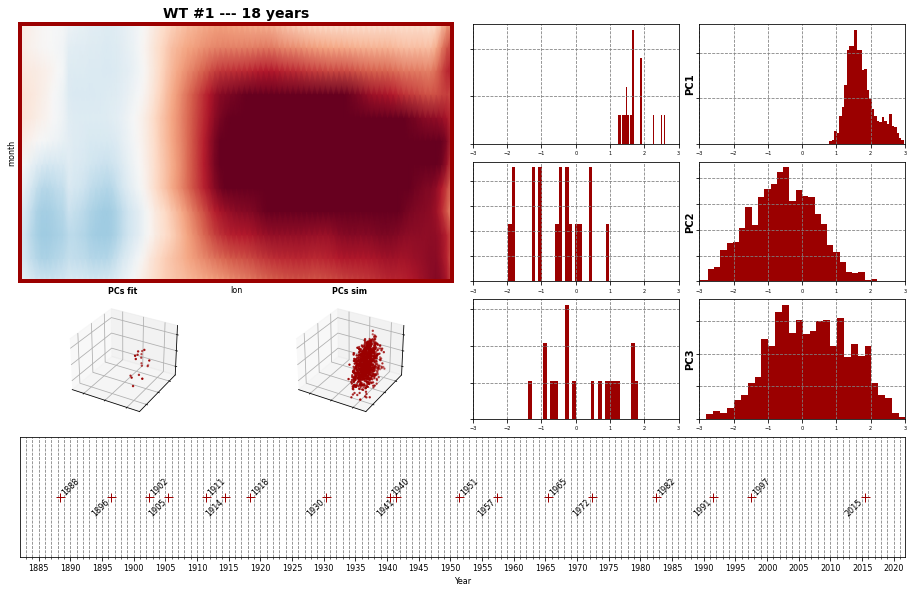

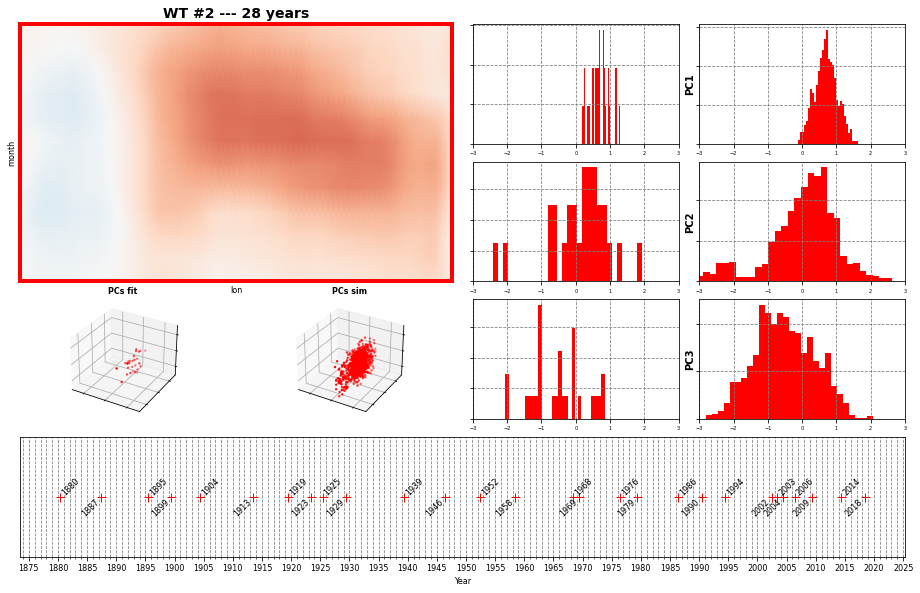

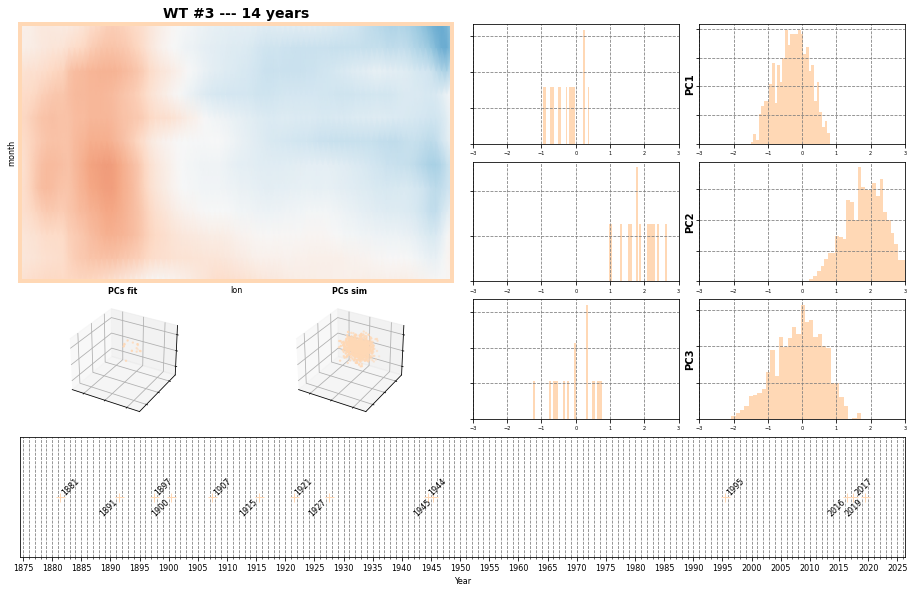

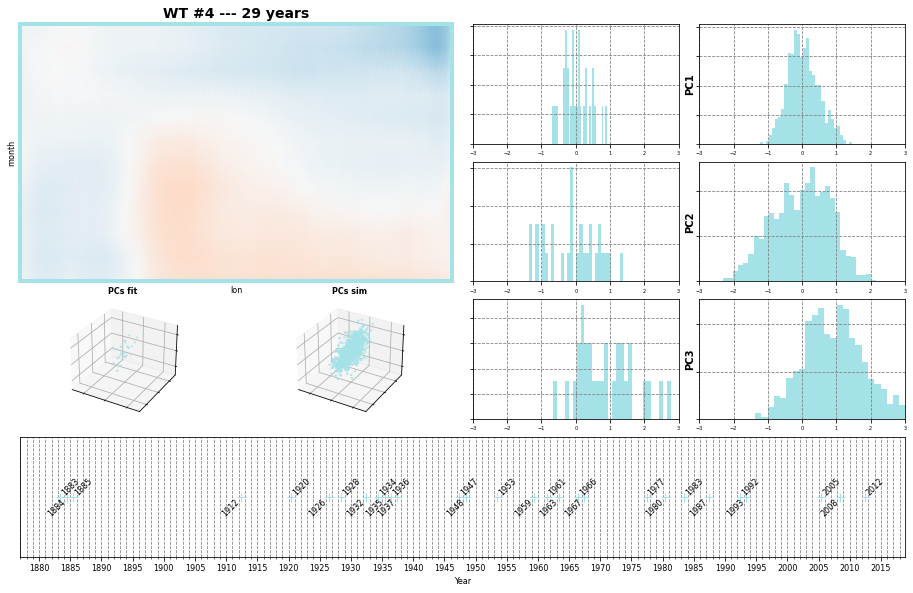

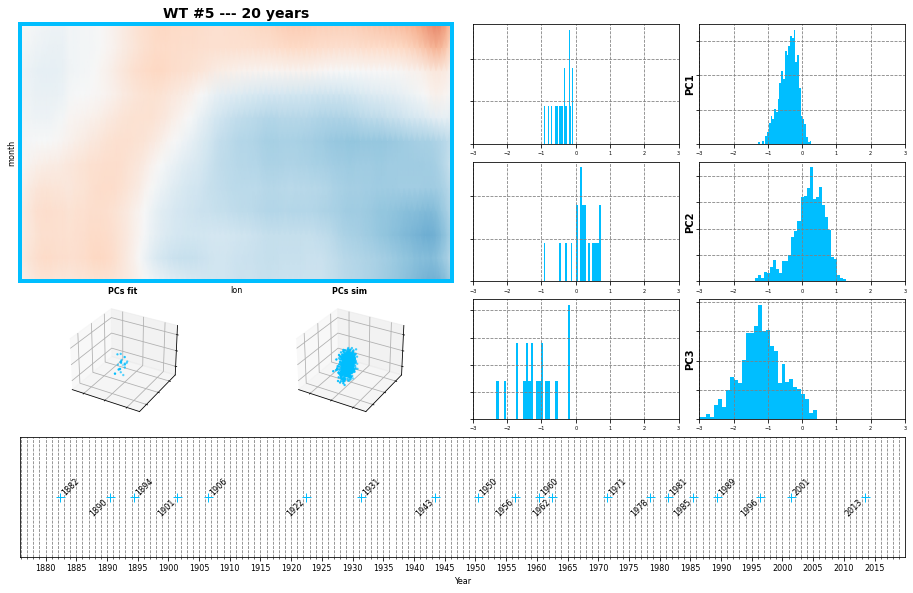

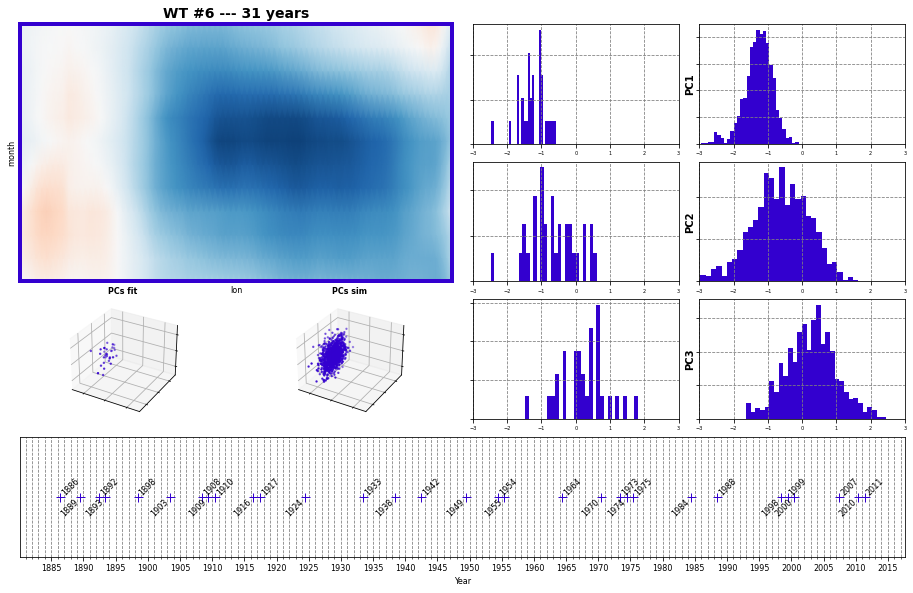

In [23]:
# Plot Annual Weather Types validation reports
Plot_AWTs_Validation(bmus, time, Km, num_clusters, lon, PCs_fit, PCs_rnd);



## Autoregressive Logistic Regression

The AWT sequence has been modeled by a second-order markov chain. Only the constant and mk_order parameters are active on the ALR settings, while the seasonality and long_term trend are deactivated. 

Initially the model is fit, and a validation is performed at the end of the notebook. 

In addition, categorical AWTs are converted to principal component space by defining tri-variate gaussian copulas (e.g. Wahl et al., 2012; Masina et al., 2015) for each AWT using the marginal distributions of its respective three PC components APC1, APC2, and APC3. Each simulated categorical ENSO is thus defined by a random number generator converted to a triplet of APC1, APC2, and APC3 from the appropriate copula, effectively providing synthetic time series with the potential to not only produce new chronologies, but also new SSTA behavior (i.e., create El Niño and La Niña events statistically consistent with observations but not exact replicas of the limited number of historical observations).

In [25]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

# bmus series
bmus_fit = xr.Dataset(
    {
        'bmus':(('time',), SST_AWTs.bmus.values[:] + 1),
    },
    coords = {'time': SST_AWTs.time.values[:]}
)

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'long_term' : False,
    'seasonality': (False, []),
}

# ALR wrapper
ALRW = ALR_WRP(db.paths.site.SST.alrw)
ALRW.SetFitData(num_clusters, bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=50000)



Fitting autoregressive logistic model ...
Optimization done in 0.06 seconds



In [26]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# simulation dates (annual array)
dates_sim = [datetime(y, pca_month_ini,1) for y in range(y1_sim-1, y2_sim+1)]

# launch simulation
ALR_sim = ALRW.Simulate(num_sims, dates_sim)

# store simulated Annual Weather Types
SST_AWTs_sim = ALR_sim.evbmus_sims.to_dataset()
print(SST_AWTs_sim)

db.Save_SST_AWT_sim(SST_AWTs_sim)


ALR model fit   : 1880-06-01 --- 2019-06-01
ALR model sim   : 1999-06-01 --- 3000-06-01

Launching 100 simulations...

Sim. Num. 100: 100%|██████████| 1000/1000 [00:00<00:00, 12648.30it/s]

<xarray.Dataset>
Dimensions:      (n_sim: 100, time: 1002)
Coordinates:
  * time         (time) object 1999-06-01 2000-06-01 ... 2999-06-01 3000-06-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 3 3 3 3 3 3 3 3 3 3 ... 4 5 4 1 2 2 2 2 6 2


PerpetualYear bmus comparison skipped.
timedelta (days): Hist - 365, Sim - 366)


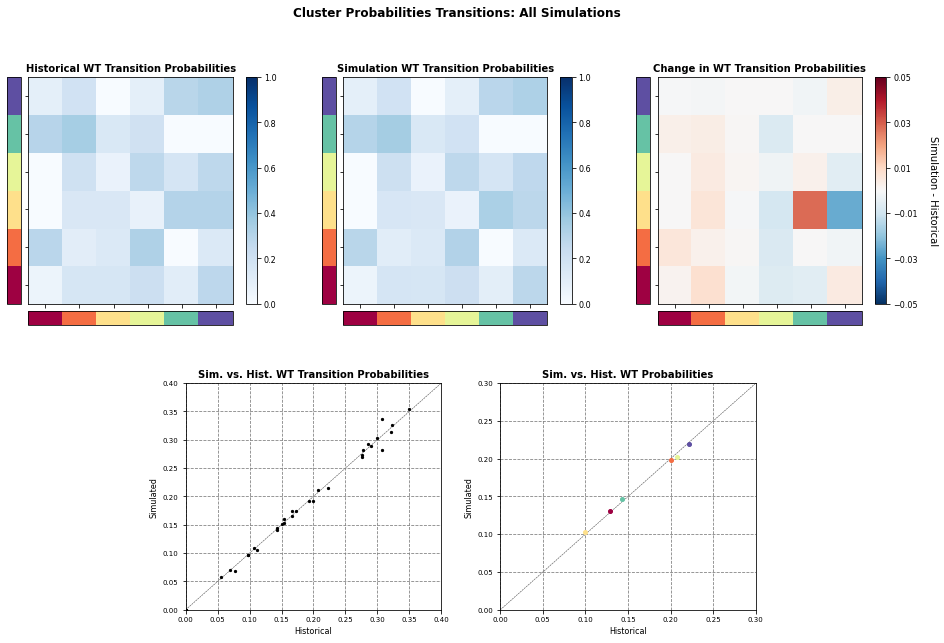

In [27]:
# show simulation report
ALRW.Report_Sim();


In [28]:
# --------------------------------------
# PCs generation

# solve each ALR simulation
l_PCs_sim = []
for s in SST_AWTs_sim.n_sim:

    evbmus_sim = SST_AWTs_sim.sel(n_sim=s).evbmus_sims.values[:]

    # generate random PCs
    pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
    for c, m in enumerate(evbmus_sim):
        options = PCs_rnd['{0}'.format(int(m))]
        r = np.random.randint(options.shape[0])
        pcs123_sim[c,:] = options[r,:]
        
    # denormalize simulated PCs
    PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(vari[0]))
    PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(vari[1]))
    PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(vari[2]))

    # append simulated PCs
    l_PCs_sim.append(
        xr.Dataset(
            {
                'PC1'  : (('time',), PC1_sim),
                'PC2'  : (('time',), PC2_sim),
                'PC3'  : (('time',), PC3_sim),
                'evbmus_sim' : (('time',), evbmus_sim),
            },
            {'time' : dates_sim}
        )
    )

# concatenate simulations
SST_PCs_sim = xr.concat(l_PCs_sim, 'n_sim')
print(SST_PCs_sim)

# store simulated PCs
db.Save_SST_PCs_sim(SST_PCs_sim)


<xarray.Dataset>
Dimensions:     (n_sim: 100, time: 1002)
Coordinates:
  * time        (time) object 1999-06-01 2000-06-01 ... 2999-06-01 3000-06-01
Dimensions without coordinates: n_sim
Data variables:
    PC1         (n_sim, time) float64 2.411 -11.84 14.34 ... -28.84 -3.618 9.051
    PC2         (n_sim, time) float64 20.97 2.366 1.011 ... 4.116 1.845 -2.467
    PC3         (n_sim, time) float64 -1.288 -9.113 8.488 ... -9.808 -2.934
    evbmus_sim  (n_sim, time) int64 3 5 2 4 5 2 6 5 4 2 ... 3 5 4 6 1 1 4 6 5 2
